✅ Data ready for modeling
Shape: (46564, 165) Class distribution: {0: 42019, 1: 4545}

=== KNN Evaluation ===
Accuracy: 0.9674302075876879
Precision: 0.8638911128903123
Recall: 0.7910557184750733
F1 Score: 0.8258706467661692


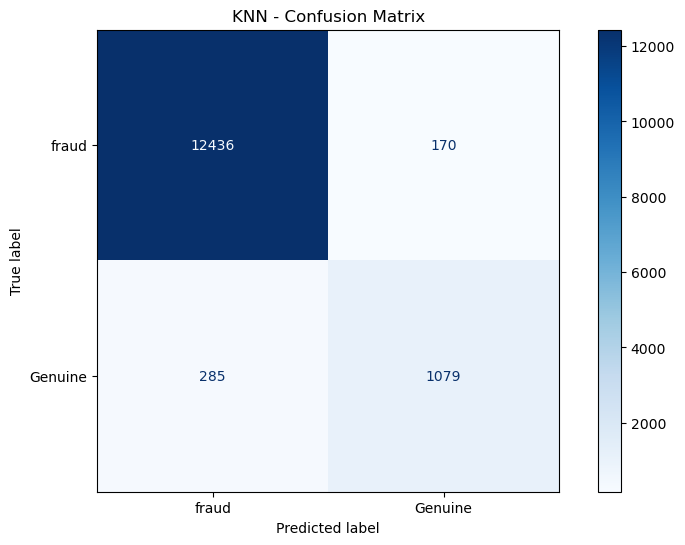


=== XGBoost Evaluation ===
Accuracy: 0.9906943450250537
Precision: 0.9597615499254843
Recall: 0.9442815249266863
F1 Score: 0.9519586104951958
ROC-AUC: 0.9967975671874353


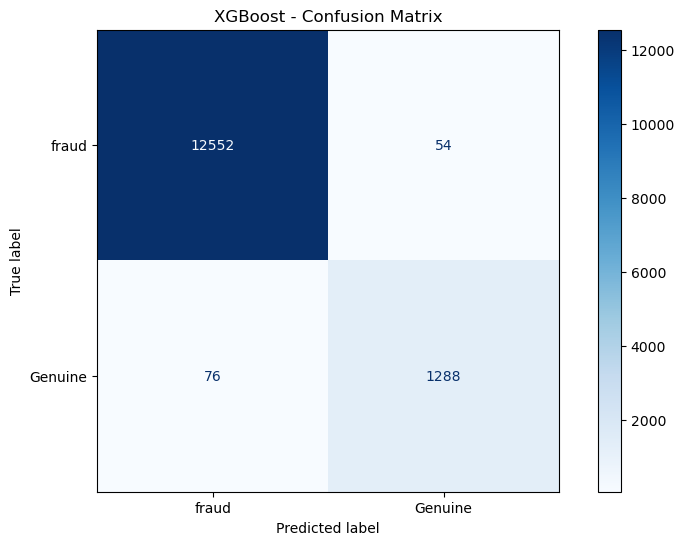

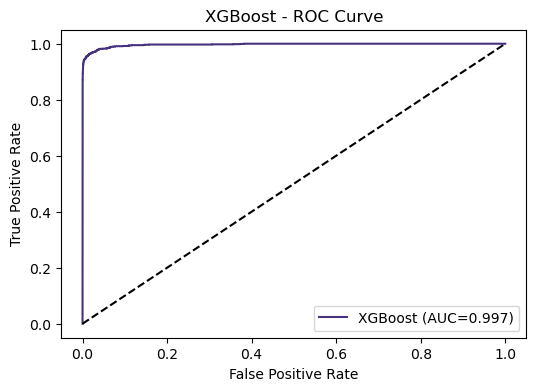

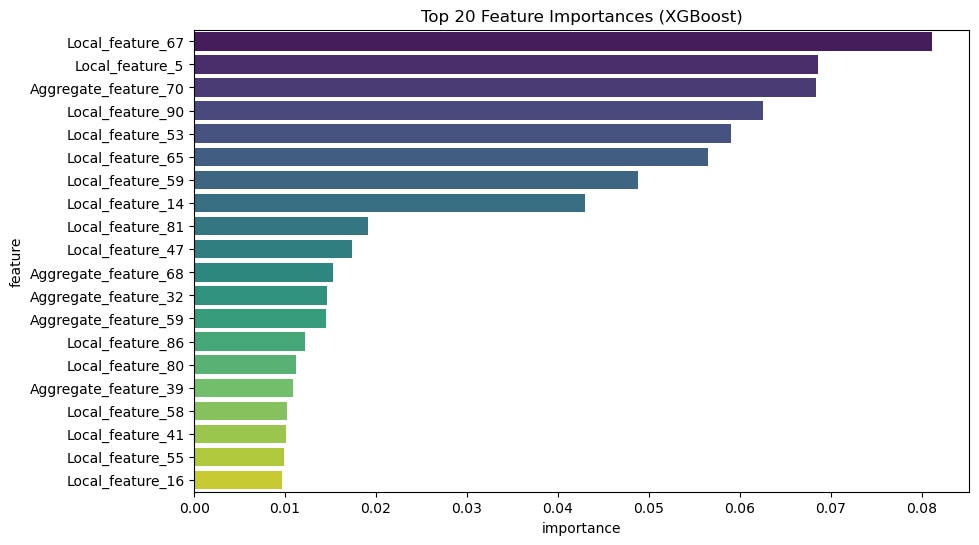

[+] Saved outputs for KNN in ./outputs/graph
[+] Saved outputs for XGBoost in ./outputs/graph


In [2]:
# =========================
# FRAUD DETECTION PIPELINE
# =========================

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (
    precision_score, f1_score, recall_score, roc_auc_score,
    accuracy_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
)
from sklearn.preprocessing import RobustScaler
from xgboost import XGBClassifier
from scipy.stats import ttest_ind
import warnings
warnings.filterwarnings('ignore')

# ----------------------
# Load & Prepare Dataset
# ----------------------
features = pd.read_csv('C:\\Users\\91766\\Downloads\\dataset\\elliptic_bitcoin_dataset\\elliptic_txs_features.csv', header=None)
classes = pd.read_csv('C:\\Users\\91766\\Downloads\\dataset\\elliptic_bitcoin_dataset\\elliptic_txs_classes.csv')

# Column renaming
colNames1 = {'0': 'txId', 1: "Time step"}
colNames2 = {str(ii+2): "Local_feature_" + str(ii+1) for ii in range(93)}
colNames3 = {str(ii+95): "Aggregate_feature_" + str(ii+1) for ii in range(72)}
colNames = dict(colNames1, **colNames2, **colNames3)
colNames = {int(jj): item_kk for jj,item_kk in colNames.items()}
features.rename(columns=colNames, inplace=True)

# Merge features and classes
df = features.merge(classes, on='txId')

# Replace unknown with 3, licit=2, illicit=1
df.loc[df['class'] == 'unknown', 'class'] = 3
df['class'] = df['class'].astype(int)

# Labeled data (licit + illicit only)
labeled_df = df[df['class'].isin([1, 2])].copy()
feature_cols = labeled_df.select_dtypes(include=['float64']).columns

# ----------------------
# Scaling
# ----------------------
scaler = RobustScaler()
X_scaled = scaler.fit_transform(labeled_df[feature_cols])

df_final = pd.DataFrame(X_scaled, columns=feature_cols, index=labeled_df.index)
df_final['class'] = labeled_df['class'].map({2: 0, 1: 1})  # 0=licit, 1=illicit

X = df_final[feature_cols]
y = df_final['class']

print("✅ Data ready for modeling")
print("Shape:", X.shape, "Class distribution:", y.value_counts().to_dict())

# ----------------------
# Train/Test Split
# ----------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

# ----------------------
# KNN Classifier
# ----------------------
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
knn_preds = knn.predict(X_test)

# ----------------------
# XGBoost Classifier
# ----------------------
xgb = XGBClassifier(
    n_estimators=200, max_depth=5, learning_rate=0.1,
    subsample=0.8, colsample_bytree=0.8, random_state=42, scale_pos_weight=10
)
xgb.fit(X_train, y_train)
xgb_preds = xgb.predict(X_test)
xgb_probs = xgb.predict_proba(X_test)[:,1]


# ----------------------
# Evaluation Function
# ----------------------
def evaluate_model(name, y_true, y_pred, y_probs=None):
    print(f"\n=== {name} Evaluation ===")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Precision:", precision_score(y_true, y_pred))
    print("Recall:", recall_score(y_true, y_pred))
    print("F1 Score:", f1_score(y_true, y_pred))
    if y_probs is not None:
        print("ROC-AUC:", roc_auc_score(y_true, y_probs))
    
    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(cm, display_labels=["fraud", "Genuine"])
    disp.plot(cmap="Blues")
    plt.title(f"{name} - Confusion Matrix")
    plt.show()

    # ROC Curve
    if y_probs is not None:
        fpr, tpr, _ = roc_curve(y_true, y_probs)
        plt.figure(figsize=(6,4))
        plt.plot(fpr, tpr, label=f"{name} (AUC={auc(fpr, tpr):.3f})")
        plt.plot([0,1], [0,1], 'k--')
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"{name} - ROC Curve")
        plt.legend()
        plt.show()
        

# ----------------------
# Evaluate Models
# ----------------------
evaluate_model("KNN", y_test, knn_preds)
evaluate_model("XGBoost", y_test, xgb_preds, xgb_probs)

# ----------------------
# Feature Importance (XGBoost)
# ----------------------
xgb_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': xgb.feature_importances_
}).sort_values(by='importance', ascending=False).head(20)

plt.figure(figsize=(10,6))
sns.barplot(x='importance', y='feature', data=xgb_importance, palette="viridis")
plt.title("Top 20 Feature Importances (XGBoost)")
plt.show()
# =========================
# Extra: Save outputs & predictions
# =========================
import os

OUT_DIR = "./outputs/graph"
os.makedirs(OUT_DIR, exist_ok=True)

def save_results(name, y_true, y_pred, y_probs=None):
    # ---- Save classification report ----
    from sklearn.metrics import classification_report
    report = classification_report(y_true, y_pred, target_names=['Genuine (0)', 'Fraud (1)'])
    with open(os.path.join(OUT_DIR, f"{name}_classification_report.txt"), "w") as f:
        f.write(report)

    # ---- Save predictions CSV ----
    results = pd.DataFrame({
        "true_label": y_true,
        "predicted_label": y_pred
    })
    if y_probs is not None:
        results["predicted_proba"] = y_probs
    results.to_csv(os.path.join(OUT_DIR, f"{name}_predictions.csv"), index=False)

    # ---- Save confusion matrix ----
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(cm, display_labels=["Genuine", "Fraud"])
    disp.plot(cmap="Blues")
    plt.title(f"{name} - Confusion Matrix")
    plt.savefig(os.path.join(OUT_DIR, f"{name}_confusion_matrix.png"))
    plt.close()

    # ---- Save ROC curve ----
    if y_probs is not None:
        fpr, tpr, _ = roc_curve(y_true, y_probs)
        roc_auc = auc(fpr, tpr)
        plt.figure(figsize=(6,4))
        plt.plot(fpr, tpr, label=f"{name} (AUC={roc_auc:.3f})")
        plt.plot([0,1], [0,1], 'k--')
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"{name} - ROC Curve")
        plt.legend()
        plt.tight_layout()
        plt.savefig(os.path.join(OUT_DIR, f"{name}_roc_curve.png"))
        plt.close()

    print(f"[+] Saved outputs for {name} in {OUT_DIR}")


# =========================
# Call saving after evaluation
# =========================
save_results("KNN", y_test, knn_preds)
save_results("XGBoost", y_test, xgb_preds, xgb_probs)
